In [1]:
# the read_txt file opens all txt file in the directory and 
# import text in all files into a list 
import glob
def read_txt(list):
    for f in read_files:
        with open(f, "rb") as infile:
            list.append(str(infile.read(), 'utf-8'))

In [2]:
# get data
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/train/neg/*.txt")
neg_train = []
read_txt(neg_train)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/train/pos/*.txt")
pos_train = []
read_txt(pos_train)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/test/neg/*.txt")
neg_test = []
read_txt(neg_test)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/test/pos/*.txt")
pos_test = []
read_txt(pos_test)

In [3]:
# define a class for our model 
class Data:
    def __init__(self, text, target):
        self.text = text
        self.target = target

In [4]:
import numpy as np
# the first input is for list of negative reviews, and the second one is for positive ones.
# we label them correspondingly with 0 and 1
def merge_data(neg,pos):
    return Data(neg + pos,np.concatenate((np.zeros(len(neg)), np.ones(len(pos)))))

In [5]:
# train-validation split where we maintain the 50:50 label ratio
train_valid_split = 2500
valid = merge_data(neg_train[:train_valid_split],pos_train[:train_valid_split])
train = merge_data(neg_train[train_valid_split:],pos_train[train_valid_split:])
test = merge_data(neg_test,pos_test)

In [126]:
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [7]:
import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [8]:
val_data_tokens, _ = tokenize_dataset(valid.text)
pkl.dump(val_data_tokens, open("val_data_1gram.p", "wb"))

In [9]:
test_data_tokens, _ = tokenize_dataset(test.text)
pkl.dump(test_data_tokens, open("test_data_1gram.p", "wb"))

In [10]:
train_data_tokens, all_train_tokens = tokenize_dataset(train.text)
pkl.dump(train_data_tokens, open("train_data_1gram.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_1gram.p", "wb"))

In [110]:
import pickle as pkl
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_1gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_1gram.p", "rb"))
val_data_tokens = pkl.load(open("val_data_1gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_1gram.p", "rb"))


In [111]:
from collections import Counter

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)


def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

In [114]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class GroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

In [115]:
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [116]:
# wrap GroupDataset function and DataLoader function 
def prepare_batch_data(data_ind, data_target, BATCH_SIZE = 50, shuffle = True):
    data = GroupDataset(data_ind, data_target)
    loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE,
                                            collate_fn=collate_func, shuffle = shuffle)
    return loader

In [117]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # set the output to 2 since we only have 2 classes 
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [305]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [13]:
# this function allows us to tune different optimization parameters
def tune_optim(optimizer_type = 'Adam',learning_rate = 0.01, annealing = False, num_epochs =10):
    # allow different kinds of optimizers
    def prep_opti(optimizer_type = 'Adam',learning_rate = learning_rate, annealing = False):
        criterion = torch.nn.CrossEntropyLoss()
        if optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_type == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        else:
            raise ValueError('Invalid Optimizer')
        if annealing:
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
            return criterion, optimizer, scheduler
        else:
            return criterion, optimizer
    
    # prepare an additional scheduler if we were using annealing of learning rate
    if annealing:
        criterion, optimizer, scheduler = prep_opti(optimizer_type = optimizer_type,learning_rate = learning_rate, annealing = True)
    else:
        criterion, optimizer = prep_opti(optimizer_type = optimizer_type,learning_rate = learning_rate, annealing = False)
     
    # use list to store output 
    _list = []
    for epoch in range(num_epochs):
        # decrease learning rate when annealing
        if annealing:
            scheduler.step()
        # for param_group in optimizer.param_groups:
        #    print(param_group['lr'])
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        _list.append( test_model(val_loader, model))
    return _list

In [15]:
learn_tune = {}
train_loader = prepare_batch_data(train_data_indices, train.target, BATCH_SIZE = 50)
val_loader = prepare_batch_data(val_data_indices, valid.target, BATCH_SIZE = 50)
# we experiment how learning rate would affect model accuracy
for rate in [0.0001, 0.001, 0.01, 0.1]:
    model = BagOfWords(len(id2token), 100)
    learn_tune[rate]  = tune_optim(learning_rate = rate, num_epochs = 50)

In [16]:
learn_tune

{0.0001: [60.42,
  65.84,
  69.2,
  70.94,
  72.36,
  73.4,
  74.6,
  75.88,
  76.88,
  77.54,
  78.2,
  79.08,
  79.76,
  80.54,
  81.04,
  81.34,
  81.84,
  82.22,
  82.62,
  83.08,
  83.4,
  83.74,
  84.0,
  84.38,
  84.44,
  84.74,
  84.84,
  84.86,
  85.1,
  85.36,
  85.6,
  85.7,
  85.86,
  85.94,
  86.0,
  86.16,
  86.24,
  86.4,
  86.46,
  86.52,
  86.54,
  86.62,
  86.6,
  86.68,
  86.86,
  86.88,
  87.06,
  87.06,
  87.14,
  87.48],
 0.001: [78.16,
  84.04,
  86.04,
  87.42,
  87.72,
  88.04,
  88.12,
  88.42,
  88.26,
  88.28,
  88.08,
  87.76,
  87.54,
  87.5,
  87.28,
  87.12,
  86.94,
  86.84,
  86.78,
  86.3,
  86.3,
  86.28,
  86.26,
  85.92,
  85.86,
  85.7,
  85.36,
  85.44,
  85.18,
  85.26,
  85.22,
  84.8,
  84.92,
  84.8,
  84.74,
  84.64,
  84.6,
  84.42,
  84.52,
  84.42,
  84.22,
  84.28,
  84.34,
  84.32,
  84.26,
  84.26,
  84.04,
  84.08,
  83.88,
  83.86],
 0.01: [88.14,
  87.38,
  86.34,
  85.56,
  85.2,
  84.38,
  84.26,
  83.48,
  83.7,
  83.54,
  83.58,

In [17]:
annealing_or_not = {}
# we experiment how annealing of learning rate would affect our model
for anne in [True, False]:
    model = BagOfWords(len(id2token), 100)
    annealing_or_not[anne]  = tune_optim(learning_rate = 0.001, annealing = anne, num_epochs = 20)

In [18]:
annealing_or_not

{True: [77.68,
  83.9,
  86.14,
  87.32,
  87.72,
  87.92,
  87.98,
  88.04,
  88.18,
  88.1,
  88.3,
  88.24,
  88.04,
  88.1,
  88.06,
  87.88,
  87.98,
  87.92,
  87.88,
  87.84],
 False: [77.82,
  83.62,
  85.94,
  86.98,
  87.5,
  87.9,
  87.92,
  87.9,
  87.92,
  87.78,
  87.54,
  87.5,
  87.4,
  87.3,
  87.18,
  86.96,
  87.08,
  86.84,
  86.6,
  86.46]}

In [125]:
optimizer_kind = {}
# we experiment how different optimizer would affect our model
for optimizer in ['Adam', 'SGD']:
    model = BagOfWords(len(id2token), 100)
    optimizer_kind[optimizer]  = tune_optim(optimizer_type = optimizer, annealing = True, learning_rate = 0.01, num_epochs = 50)

In [126]:
optimizer_kind

{'Adam': [87.7,
  87.38,
  86.84,
  85.84,
  85.42,
  84.86,
  84.16,
  83.58,
  83.64,
  83.52,
  83.54,
  83.44,
  83.52,
  83.54,
  83.5,
  83.48,
  83.34,
  83.14,
  83.22,
  83.22,
  83.12,
  83.18,
  83.16,
  83.08,
  83.14,
  83.16,
  83.1,
  83.2,
  83.12,
  83.1,
  83.02,
  83.04,
  83.02,
  83.0,
  82.96,
  82.88,
  82.98,
  82.88,
  82.98,
  82.92,
  82.92,
  82.92,
  82.96,
  82.86,
  83.0,
  83.02,
  82.94,
  82.94,
  82.84,
  82.76],
 'SGD': [55.06,
  58.36,
  59.5,
  62.64,
  62.2,
  62.68,
  63.46,
  63.36,
  63.96,
  63.86,
  64.06,
  64.26,
  64.44,
  64.38,
  64.24,
  64.3,
  64.4,
  64.46,
  64.54,
  64.62,
  64.7,
  64.86,
  65.0,
  65.02,
  65.04,
  65.1,
  65.0,
  65.22,
  65.1,
  65.22,
  65.12,
  65.16,
  65.28,
  65.24,
  65.34,
  65.36,
  65.44,
  65.42,
  65.34,
  65.34,
  65.3,
  65.36,
  65.36,
  65.34,
  65.36,
  65.38,
  65.4,
  65.38,
  65.46,
  65.44]}

In [ ]:
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [131]:
def tokenize_dataset_n(dataset, ngram = 1):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        # join n consecutive single grams and consist n-grams
        grams = [' '.join(tokens[i:i+ngram]) for i in range(len(tokens)-ngram+1)]
        token_dataset.append(grams)
        all_tokens += grams

    return token_dataset, all_tokens

In [ ]:
# prepare data for n grams, as we did for single gram case
val_data_2_gram, _ = tokenize_dataset_n(valid.text, ngram =2 )
pkl.dump(val_data_2_gram, open("val_data_2gram.p", "wb"))
test_data_2_gram, _ = tokenize_dataset_n(test.text, ngram =2 )
pkl.dump(test_data_2_gram, open("test_data_2gram.p", "wb"))

val_data_3_gram, _ = tokenize_dataset_n(valid.text, ngram =3 )
pkl.dump(val_data_3_gram, open("val_data_3gram.p", "wb"))
test_data_3_gram, _ = tokenize_dataset_n(test.text, ngram =3 )
pkl.dump(test_data_3_gram, open("test_data_3gram.p", "wb"))

val_data_4_gram, _ = tokenize_dataset_n(valid.text, ngram =4 )
pkl.dump(val_data_4_gram, open("val_data_4gram.p", "wb"))
test_data_4_gram, _ = tokenize_dataset_n(test.text, ngram =4 )
pkl.dump(test_data_4_gram, open("test_data_4gram.p", "wb"))

train_data_2_gram, all_train_2_gram = tokenize_dataset_n(train.text, ngram =2 )
pkl.dump(train_data_2_gram, open("train_data_2gram.p", "wb"))
pkl.dump(all_train_2_gram, open("all_train_2gram.p", "wb"))

train_data_3_gram, all_train_3_gram = tokenize_dataset_n(train.text, ngram =3 )
pkl.dump(train_data_3_gram, open("train_data_3gram.p", "wb"))
pkl.dump(all_train_3_gram, open("all_train_3gram.p", "wb"))

train_data_4_gram, all_train_4_gram = tokenize_dataset_n(train.text, ngram =4 )
pkl.dump(train_data_4_gram, open("train_data_4gram.p", "wb"))
pkl.dump(all_train_4_gram, open("all_train_4gram.p", "wb"))

In [66]:
# this function allows us to tune different model hyperparameters
def tune_model(ngram = 1, vocab_size = 10000, emb_size = 100):
    
    if ngram == 1: 
        train_data_tokens = pkl.load(open("train_data_1gram.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_1gram.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_1gram.p", "rb"))
    if ngram == 2: 
        train_data_tokens = pkl.load(open("train_data_2gram.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_2gram.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_2gram.p", "rb"))
    if ngram == 3: 
        train_data_tokens = pkl.load(open("train_data_3gram.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_3gram.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_3gram.p", "rb"))
    if ngram == 4: 
        train_data_tokens = pkl.load(open("train_data_4gram.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_4gram.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_4gram.p", "rb"))
    PAD_IDX = 0
    UNK_IDX = 1

    def build_vocab(all_tokens, max_vocab_size = vocab_size):
        # Returns:
        # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
        # token2id: dictionary where keys represent tokens and corresponding values represent indices
        token_counter = Counter(all_tokens)
        vocab, count = zip(*token_counter.most_common(max_vocab_size))
        id2token = list(vocab)
        token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
        id2token = ['<pad>', '<unk>'] + id2token
        token2id['<pad>'] = PAD_IDX 
        token2id['<unk>'] = UNK_IDX
        return token2id, id2token
      
    token2id, id2token = build_vocab(all_train_tokens,vocab_size)
    
    # we need to get new indices mapping after changing the vocab size
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    
    train_loader = prepare_batch_data(train_data_indices, train.target, BATCH_SIZE = 50)
    val_loader = prepare_batch_data(val_data_indices, valid.target, BATCH_SIZE = 50)
    
    model = BagOfWords(len(id2token), emb_size)
    # use the optimization parameters we have tuned 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    
    _list = []
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        _list.append( test_model(val_loader, model))
    return _list

In [60]:
n_gram = {}
# get training data for different grams
for gram in [1,2,3,4]:
    n_gram[gram] = tune_model(ngram = gram)

In [61]:
n_gram

{1: [77.38,
  84.02,
  85.74,
  86.8,
  87.86,
  88.06,
  88.18,
  88.38,
  88.14,
  88.3,
  88.3,
  88.4,
  88.34,
  88.2,
  88.26,
  88.14,
  88.04,
  87.92,
  88.02,
  88.02],
 2: [65.6,
  79.06,
  80.96,
  82.34,
  83.0,
  83.42,
  83.64,
  83.8,
  83.88,
  83.8,
  84.08,
  84.08,
  84.16,
  84.18,
  84.06,
  84.16,
  84.06,
  84.06,
  84.02,
  83.96],
 3: [56.78,
  58.62,
  74.56,
  74.22,
  76.16,
  76.78,
  77.48,
  77.82,
  78.2,
  77.6,
  78.3,
  77.88,
  78.68,
  78.66,
  78.72,
  78.8,
  78.3,
  78.86,
  78.68,
  78.86],
 4: [50.0,
  59.18,
  51.86,
  69.32,
  60.92,
  57.24,
  64.88,
  71.52,
  71.52,
  72.14,
  72.56,
  72.52,
  72.6,
  72.68,
  72.92,
  72.82,
  73.14,
  73.12,
  73.0,
  72.64]}

In [62]:
voc_size = {}
# get training data for different vocab. size 
for vocab_size in [3000, 10000, 25000,100000]:
    voc_size[vocab_size] = tune_model(ngram = 1, vocab_size = vocab_size)

In [63]:
voc_size

{3000: [77.26,
  82.74,
  84.36,
  84.7,
  85.92,
  85.84,
  86.14,
  86.46,
  86.3,
  86.42,
  86.56,
  86.4,
  86.32,
  86.3,
  86.34,
  86.22,
  86.24,
  86.3,
  86.06,
  86.12],
 10000: [78.36,
  83.32,
  85.26,
  86.44,
  87.04,
  87.52,
  87.86,
  87.94,
  87.94,
  88.28,
  88.02,
  88.04,
  88.08,
  88.12,
  87.96,
  87.98,
  87.88,
  87.88,
  87.8,
  87.84],
 25000: [78.22,
  84.46,
  86.02,
  87.26,
  87.92,
  88.38,
  88.32,
  88.36,
  88.5,
  88.46,
  88.44,
  88.5,
  88.34,
  88.44,
  88.4,
  88.36,
  88.4,
  88.18,
  88.16,
  88.14],
 100000: [78.32,
  83.7,
  85.94,
  87.26,
  87.8,
  88.06,
  88.42,
  88.48,
  88.46,
  88.48,
  88.42,
  88.56,
  88.52,
  88.5,
  88.44,
  88.16,
  88.02,
  88.16,
  88.16,
  88.18]}

In [ ]:
embd_size = {}
# try embedding size
for embd in [25, 100, 200, 500]:
    embd_size[embd] = tune_model(ngram = 1, vocab_size = 25000, emb_size = embd)

In [72]:
embd_size

{25: [72.74,
  80.92,
  83.3,
  84.6,
  85.54,
  86.1,
  86.52,
  86.86,
  87.12,
  87.42,
  87.64,
  87.86,
  87.84,
  87.98,
  87.9,
  87.82,
  87.96,
  88.02,
  88.16,
  88.12],
 100: [78.92,
  84.48,
  86.22,
  87.18,
  87.54,
  88.02,
  88.32,
  88.42,
  88.44,
  88.54,
  88.38,
  88.48,
  88.36,
  88.58,
  88.36,
  88.34,
  88.22,
  88.2,
  88.12,
  87.88],
 200: [80.6,
  85.74,
  87.08,
  87.96,
  88.38,
  88.66,
  88.64,
  88.72,
  88.68,
  88.6,
  88.46,
  88.42,
  88.44,
  88.4,
  88.38,
  88.22,
  88.06,
  88.06,
  87.76,
  87.96],
 500: [83.46,
  87.12,
  87.96,
  88.88,
  88.8,
  88.6,
  88.12,
  88.44,
  88.12,
  88.34,
  87.78,
  87.74,
  87.9,
  87.58,
  87.42,
  87.4,
  87.04,
  87.32,
  87.24,
  86.9]}

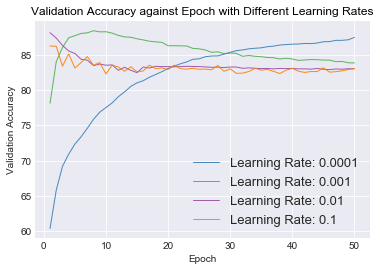

In [306]:
import pandas as pd
df_x = pd.DataFrame({'Epoch': range(1,51)})
df_y = pd.DataFrame(learn_tune)
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num=0
# now we plot cures based on the data we have 
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Learning Rate: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Different Learning Rates", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

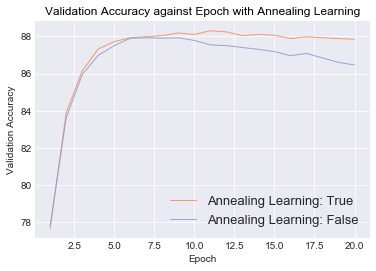

In [289]:
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(annealing_or_not)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
num=0
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Annealing Learning: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Annealing Learning", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

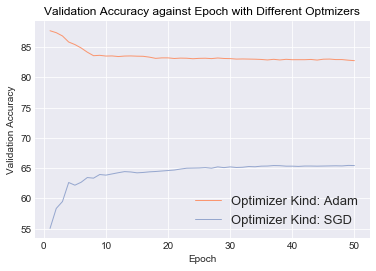

In [290]:
df_x = pd.DataFrame({'Epoch': range(1,51)})
df_y = pd.DataFrame(optimizer_kind)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
num=0
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Optimizer Kind: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Different Optmizers", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

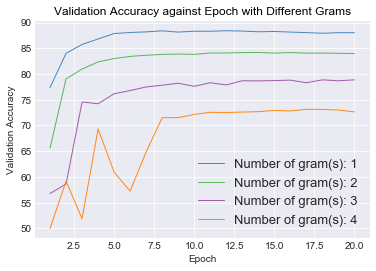

In [291]:
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(n_gram)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num=0
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Number of gram(s): ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Different Grams", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

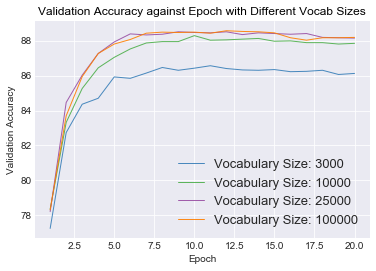

In [292]:
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(voc_size)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num=0
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Vocabulary Size: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Different Vocab Sizes", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

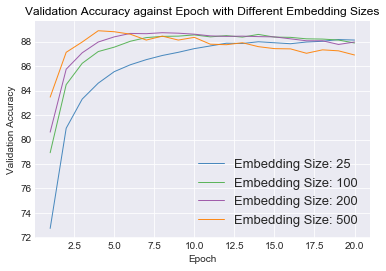

In [293]:
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(embd_size)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num=0
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Embedding Size: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Different Embedding Sizes", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

In [139]:
# remove punctuation but retain capitalizations
def tokenize_w_cap(sent):
  tokens = tokenizer(sent)
  return [token.text for token in tokens if (token.text not in punctuations)]

In [147]:
def tokenize_dataset_w_cap(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize_w_cap(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [148]:
# get data capitalization 
val_data_1_gram_w_Cap, _ = tokenize_dataset_w_cap(valid.text)
pkl.dump(val_data_1_gram_w_Cap, open("val_data_1_gram_w_Cap.p", "wb"))

train_data_1_gram_w_Cap, all_train_1_gram_w_Cap = tokenize_dataset_w_cap(train.text)
pkl.dump(train_data_1_gram_w_Cap, open("train_data_1_gram_w_Cap.p", "wb"))
pkl.dump(all_train_1_gram_w_Cap, open("all_train_1_gram_w_Cap.p", "wb"))

In [307]:
def build_vocab(all_tokens, max_vocab_size = 25000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [133]:
def compare_scheme(with_cap = True):
    if with_cap: 
        train_data_tokens = pkl.load(open("train_data_1_gram_w_Cap.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_1_gram_w_Cap.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_1gram.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_1gram.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_1gram.p", "rb"))   
    PAD_IDX = 0
    UNK_IDX = 1

    token2id, id2token = build_vocab(all_train_tokens)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_loader = prepare_batch_data(train_data_indices, train.target, BATCH_SIZE = 50)
    val_loader = prepare_batch_data(val_data_indices, valid.target, BATCH_SIZE = 50)
    model = BagOfWords(len(id2token), 500)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    
    _list = []
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            # if i > 0 and i % 200 == 0:
                # validate
            #    val_acc = test_model(val_loader, model)
            #    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
            #               epoch+1, 10, i+1, len(train_loader), val_acc))
        print(epoch)
        _list.append( test_model(val_loader, model))
    return _list  

In [ ]:
w_Cap = {}
# get data for capitalization accuracy
for cap in [True, False]:
    w_Cap[cap] = compare_scheme(with_cap = cap)

In [303]:
w_Cap

{True: [82.8,
  86.92,
  88.22,
  88.08,
  88.54,
  88.76,
  88.42,
  88.52,
  88.4,
  88.16,
  87.86,
  87.98,
  87.78,
  87.64,
  87.58,
  87.52,
  87.32,
  87.46,
  87.36,
  87.38],
 False: [83.52,
  86.52,
  87.9,
  88.28,
  88.68,
  88.56,
  88.64,
  88.48,
  88.26,
  88.24,
  88.12,
  87.94,
  87.78,
  87.62,
  87.62,
  87.44,
  87.46,
  87.24,
  87.14,
  87.24]}

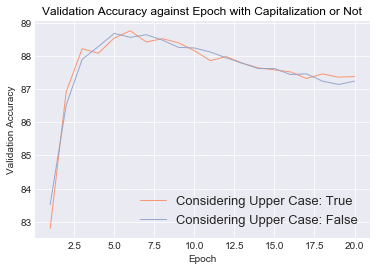

In [294]:
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(w_Cap)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
num=0
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Considering Upper Case: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Capitalization or Not", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy") 

In [155]:
test_data_1_gram_w_Cap, _ = tokenize_dataset_w_cap(test.text)
pkl.dump(test_data_1_gram_w_Cap, open("test_data_1_gram_w_Cap.p", "wb"))

In [296]:
import copy
def build_final_model():
    train_data_tokens = pkl.load(open("train_data_1_gram_w_Cap.p", "rb"))
    all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
    val_data_tokens = pkl.load(open("val_data_1_gram_w_Cap.p", "rb"))
    PAD_IDX = 0
    UNK_IDX = 1   
    token2id, id2token = build_vocab(all_train_tokens)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_loader = prepare_batch_data(train_data_indices, train.target, BATCH_SIZE = 50)
    val_loader = prepare_batch_data(val_data_indices, valid.target, BATCH_SIZE = 50)
    model = BagOfWords(len(id2token), 500)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    # _list = []
    _list = [0]
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        # early stopping: if the validation accuray does not increse any more
        # we stop the iteration and return our last model
        if (_list[-1] <= test_model(val_loader, model) ):
            # update model with higher validation accuracy
            model_copy = copy.deepcopy(model)
        else:
            # return previous model if the accuracy fails to increse to prevent over-fit
            return model_copy
        _list.append( test_model(val_loader, model))
    # return _list

In [ ]:
final_model = build_final_model()

In [297]:
final__ = build_final_model()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


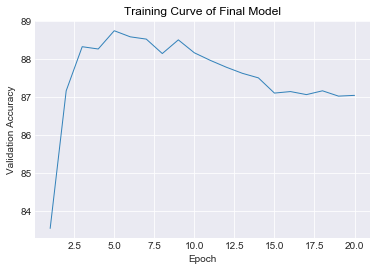

In [302]:
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(final__[1:])
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
num=0
for column in df_y:
    # num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', linewidth=1, alpha=0.9)
    plt.title("Training Curve of Final Model", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy") 

In [164]:
val_data_tokens = pkl.load(open("val_data_1_gram_w_Cap.p", "rb"))
test_data_tokens = pkl.load(open("test_data_1_gram_w_Cap.p", "rb"))
all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
PAD_IDX = 0
UNK_IDX = 1   
token2id, id2token = build_vocab(all_train_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
val_loader = prepare_batch_data(val_data_indices, valid.target, BATCH_SIZE = 50)
test_loader = prepare_batch_data(test_data_indices, test.target, BATCH_SIZE = 50, shuffle = False)

In [249]:
print ("Val Acc {}".format(test_model(val_loader, final_model)))
print ("Test Acc {}".format(test_model(test_loader, final_model)))

Val Acc 88.78
Test Acc 85.288


In [259]:
def print_predictions(loader, model):
    # use this function to print prediction samples
    correct = {}
    wrong = {}
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        for ind in range(50):
            # record correct indices data to the correct file
            if (predicted.data.tolist()[ind][0] == labels.data.tolist()[ind]):
                correct[ind] = data[ind].tolist()
            else:
                wrong[ind] = data[ind].tolist()
        # stop when we have enough data
        if (len(correct) > 3) and (len(wrong) > 3):
            break
    return correct, wrong

In [264]:
cor, wro = print_predictions(val_loader,final_model)

In [280]:
temp_tokens = []
# extract meaningful word indices
for id in wro[3]:
    # stop at padding indices
    if id == 0:
        break
    # transform indices to text
    temp_tokens.append(id2token[id])
[' '.join(temp_tokens)]

['The main reason to see this film is Warren William who is in top form as the <unk> campaign manager He is electric constantly finding ways to fool the public and defeat the opposing party in the midst of the biggest disasters William is a great actor -- I feel he never got his due Bette Davis as his girlfriend also shines in an under written role Personally I found Guy <unk> not quite right as the lame brained candidate that William and the others are trying to <unk> on the public He seemed more like an empty canvas than a person I would have preferred to see a real character emerge rather than a non character The story itself is implausible silly and clichéd But Warren William and Bette Davis are well worth watching']

In [281]:
temp_tokens = []
for id in wro[6]:
    if id == 0:
        break
    temp_tokens.append(id2token[id])
[' '.join(temp_tokens)]

["A lot of the user comments i have seen on the IMDB for this movie do n't really do it justice First of all let me just say that this movie is not to be taken seriously It 's supposed to be a fun yet stupid movie that does n't require one to think only to enjoy it If you watch this movie with the intent to see a masterpiece in either filmmaking or in humour then you will be sorely disappointed Yet if you want to just watch a goofy movie with some talented actors actresses and some good catch phrases then you will enjoy it"]

In [282]:
temp_tokens = []
for id in wro[43]:
    if id == 0:
        break
    temp_tokens.append(id2token[id])
[' '.join(temp_tokens)]

["I have complained to ABC about the cancellation of six degrees If enough people do the same then it could be enough to bring this fabulous show back to life Just go onto the official site and the rest is simple enough I do not understand why this show has been cancelled What a fantastic show cast and characters The whole concept is gripping viewing I am <unk> that my favourite show is over after just one series Why is this Six degrees is phenomenal it 's better than so many other TV programmes out there Until I heard they were stopping it from a friend it had n't even occurred to me that this might happen"]

In [283]:
temp_tokens = []
for id in cor[1]:
    if id == 0:
        break
    temp_tokens.append(id2token[id])
[' '.join(temp_tokens)]

["I admit I had to fast forward through this poorly transferred DVD after about 30 minutes -- NOTHING was happening and everyone has already described the plot But has anyone mentioned the opening scene -- a butcher knife is stabbed through a wig and it 's impaled on the grass in the front yard I 'm guessing the bratty kid did it put it 's never explained Really trippy <unk> /><br />I wish this had been a better written or thought out film because what we 're left with if pretty daft and a movie that makes no sense is n't a clever movie it 's just a poorly executed film.<br /><br />I would like to see a cleaned up version and if there was any missing footage I would like to see if it would help Otherwise this is an odd little film that is best if fast forwarded through"]

In [284]:
temp_tokens = []
for id in cor[2]:
    if id == 0:
        break
    temp_tokens.append(id2token[id])
[' '.join(temp_tokens)]

["This is one creepy movie <unk> than anything David Lynch and that shows what a great director Polanski is since this is not his usual type of work and it is <unk> /><br />It all starts of with <unk> moves into a <unk> block in Paris He soon learns that the previous tenant a young woman committed suicide and he believes the rest of the people living there drove her to it He also believes that they are trying to do the same to him What results is a amazing and frightening look at <unk> /><br />The whole production has classical horror written all over it from the imagery to the music the viewer can feel poor <unk> 's terror building up.<br /><br />Are they all out to kill him Or maybe just drive him mad Is there a difference Find out for yourself 10/10"]

In [285]:
temp_tokens = []
for id in cor[7]:
    if id == 0:
        break
    temp_tokens.append(id2token[id])
[' '.join(temp_tokens)]

["<unk> was a bold film by Raj <unk> at it 's time In 1997 when such a topic was damn out of the box br /><br />To give him his credit he does succeed in showing how greed changes a person and to what extent the person can go to get what she wants br /><br />The film however is damn melodramatic many places ridiculous br /><br />One wonders why Anil does n't buy a TV for his wife when he earns so much Just to show how poor he <unk> /><br />The twist is well handled but the handling is straight out of 80 's The <unk> Paresh comedy which entertains here and there stands out as a sore thumb as it does n't fit in the story br /><br />Even there are several <unk> scenes br /><br />Direction by Raj <unk> is adequate though at times too melodramatic Music is okay but most songs look forced br /><br <unk> does his part well <unk> is excellent in her part Urmila is decent Amongst rest <unk> Khan is as usual Johny <unk> is funny Paresh irritates <unk> is decent"]